# CoronaData

### Analyze open data of RIVM 
Johan van Voskuilen, 16-08-2020 (first)

Todo: add temperature data to look for trends; use https://cdn.knmi.nl/knmi/map/page/klimatologie/gegevens/daggegevens/etmgeg_260.zip which gives homogenised temperature data (a.o.) from De Bilt.

##### Import Python modules

In [1]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import urllib.request

##### Import data

In [2]:
dataurl = 'https://data.rivm.nl/covid-19/COVID-19_aantallen_gemeente_cumulatief.csv'
with urllib.request.urlopen(dataurl) as response:
    df = pd.read_csv(response, delimiter=';', parse_dates=[0], index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 71198 entries, 2020-03-13 10:00:00 to 2020-09-22 10:00:00
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Municipality_code   68870 non-null  object
 1   Municipality_name   68870 non-null  object
 2   Province            71198 non-null  object
 3   Total_reported      71198 non-null  int64 
 4   Hospital_admission  71198 non-null  int64 
 5   Deceased            71198 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 3.8+ MB


In [3]:
df.describe()

,Total_reported,Hospital_admission,Deceased
count,71198.000000,71198.000000,71198.000000
mean,127.848100,28.301891,13.680946
std,316.145669,51.377411,28.170543
min,0.000000,0.000000,0.000000
25%,30.000000,7.000000,2.000000
50%,67.000000,16.000000,6.000000
75%,135.000000,31.000000,15.000000
max,10338.000000,720.000000,359.000000


##### Analyze data

###### Analyze cumulative per day

In [4]:
df['2020-03-13'].sum()

Province              GroningenGroningenGroningenGroningenFlevolandG...
Total_reported                                                      804
Hospital_admission                                                  115
Deceased                                                              9
dtype: object

In [5]:
CumulativePerDay = df.groupby(df.index.date).sum()

In [6]:
CumulativePerDay.index

Index([2020-03-13, 2020-03-14, 2020-03-15, 2020-03-16, 2020-03-17, 2020-03-18,
       2020-03-19, 2020-03-20, 2020-03-21, 2020-03-22,
       ...
       2020-09-13, 2020-09-14, 2020-09-15, 2020-09-16, 2020-09-17, 2020-09-18,
       2020-09-19, 2020-09-20, 2020-09-21, 2020-09-22],
      dtype='object', length=194)

###### Calculate differential per day

In [7]:
CumulativePerDay

,Total_reported,Hospital_admission,Deceased
2020-03-13,804,115,9
2020-03-14,959,136,12
2020-03-15,1135,162,19
2020-03-16,1413,205,23
2020-03-17,1705,314,40
...,...,...,...
2020-09-18,90047,12356,6273
2020-09-19,91934,12389,6275
2020-09-20,93778,12409,6279
2020-09-21,95995,12435,6281


In [8]:
DifferencePerDay = CumulativePerDay.diff().fillna(CumulativePerDay).astype(int)
DifferencePerDay.tail(25)

,Total_reported,Hospital_admission,Deceased
2020-08-29,501,2,4
2020-08-30,508,3,0
2020-08-31,527,11,0
2020-09-01,462,5,6
2020-09-02,734,6,5
2020-09-03,601,5,0
2020-09-04,744,7,2
2020-09-05,654,5,4
2020-09-06,925,5,2
2020-09-07,797,9,0


###### Add rolling mean for total reported

In [9]:
DifferencePerDay['Total_reported_rollingmean3days'] = DifferencePerDay['Total_reported'].rolling(3, min_periods=1).mean()
DifferencePerDay['Hospital_admission_rollingmean3days'] = DifferencePerDay['Hospital_admission'].rolling(3, min_periods=1).mean()
DifferencePerDay['Deceased_rollingmean3days'] = DifferencePerDay['Deceased'].rolling(3, min_periods=1).mean()
DifferencePerDay.tail()

,Total_reported,Hospital_admission,Deceased,Total_reported_rollingmean3days,Hospital_admission_rollingmean3days,Deceased_rollingmean3days
2020-09-18,1974,12,7,1756.333333,13.666667,5.000000
2020-09-19,1887,33,2,1871.333333,19.666667,5.000000
2020-09-20,1844,20,4,1901.666667,21.666667,4.333333
2020-09-21,2217,26,2,1982.666667,26.333333,2.666667
2020-09-22,2245,32,10,2102.000000,26.000000,5.333333


###### Weekly rolling sum of new reported cases, hospital admissions and deceased

In [10]:
Weekly = pd.DataFrame(index=DifferencePerDay.index)
Weekly['New_reported_rollingsum1week'] = DifferencePerDay['Total_reported'].rolling(7, min_periods=1).sum()
Weekly['Hospital_admission_rollingsum1week'] = DifferencePerDay['Hospital_admission'].rolling(7, min_periods=1).sum()
Weekly['Deceased_rollingsum1week'] = DifferencePerDay['Deceased'].rolling(7, min_periods=1).sum()
Weekly.tail()

,New_reported_rollingsum1week,Hospital_admission_rollingsum1week,Deceased_rollingsum1week
2020-09-18,10266.0,96.0,21.0
2020-09-19,10922.0,123.0,22.0
2020-09-20,11679.0,126.0,25.0
2020-09-21,12596.0,144.0,25.0
2020-09-22,13462.0,152.0,33.0


##### Plot results

Plot of cumulative numbers

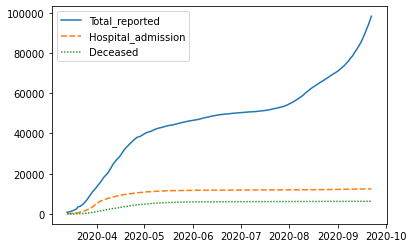

In [11]:
ax = sns.lineplot(data = CumulativePerDay)

Plot of last days (cumulative)

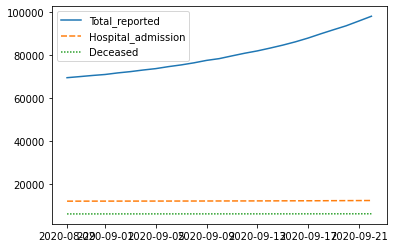

In [12]:
ax = sns.lineplot(data = CumulativePerDay[-25:])

Plot of difference per day

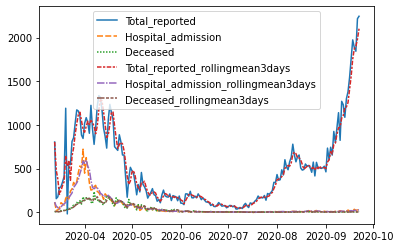

In [13]:
ax = sns.lineplot(data=DifferencePerDay)

Zoom in on hospital admissions and deceased:

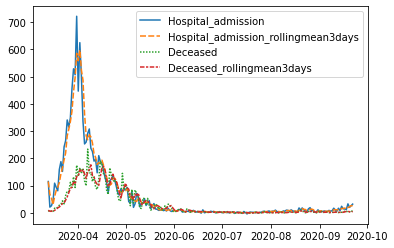

In [14]:
ax = sns.lineplot(data=DifferencePerDay.loc[:, ['Hospital_admission', 'Hospital_admission_rollingmean3days', 'Deceased', 'Deceased_rollingmean3days']])

Plot of last days (differential)

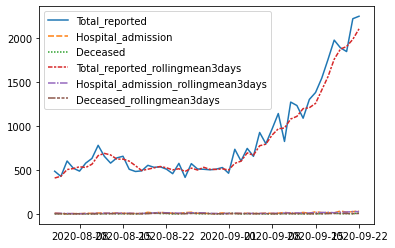

In [15]:
ax = sns.lineplot(data=DifferencePerDay[-50:])

Results of last days:

In [25]:
DifferencePerDay.tail(10)

,Total_reported,Hospital_admission,Deceased,Total_reported_rollingmean3days,Hospital_admission_rollingmean3days,Deceased_rollingmean3days
2020-09-13,1087,17,1,1196.000000,11.000000,1.666667
2020-09-14,1300,8,2,1206.000000,10.333333,1.333333
2020-09-15,1379,24,2,1255.333333,16.333333,1.666667
2020-09-16,1542,15,2,1407.000000,15.666667,2.000000
2020-09-17,1753,14,6,1558.000000,17.666667,3.333333
2020-09-18,1974,12,7,1756.333333,13.666667,5.000000
2020-09-19,1887,33,2,1871.333333,19.666667,5.000000
2020-09-20,1844,20,4,1901.666667,21.666667,4.333333
2020-09-21,2217,26,2,1982.666667,26.333333,2.666667
2020-09-22,2245,32,10,2102.000000,26.000000,5.333333


Weekly result of new reported cases:

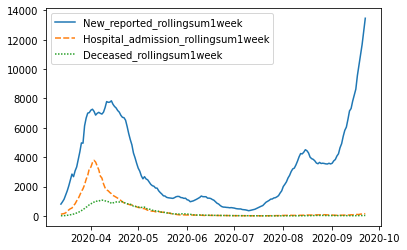

In [17]:
ax = sns.lineplot(data=Weekly)

Weekly result of hospital admission and deceased:

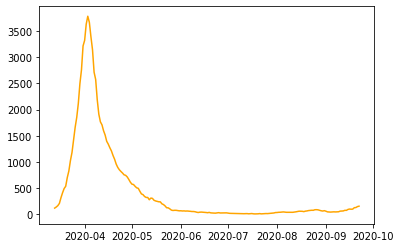

In [22]:
ax = sns.lineplot(data=Weekly['Hospital_admission_rollingsum1week'], color='orange')

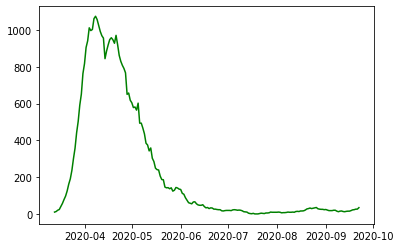

In [23]:
ax = sns.lineplot(data=Weekly['Deceased_rollingsum1week'], color='green')